# Intro

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model
from sklearn.pipeline import Pipeline
import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline

In [2]:
train_features = pd.read_pickle('catfeatures_train.pkl',compression='zip')
test_features = pd.read_pickle('catfeatures_test.pkl',compression='zip')

In [3]:
train = pd.read_pickle('train.pkl',compression='zip')
test = pd.read_pickle('test.pkl',compression='zip')

In [101]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_features', 3149673384),
 ('test_features', 1065177714),
 ('new_features', 24054888),
 ('Pipeline', 1056),
 ('color', 176),
 ('miss_vars', 88),
 ('ensemble', 80),
 ('feature_selection', 80),
 ('impute', 80),
 ('lgb', 80),
 ('linear_model', 80),
 ('metrics', 80),
 ('model_selection', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('preprocessing', 80),
 ('sns', 80),
 ('imputer', 56),
 ('indicator', 56)]

# Other Features

## Day of Week

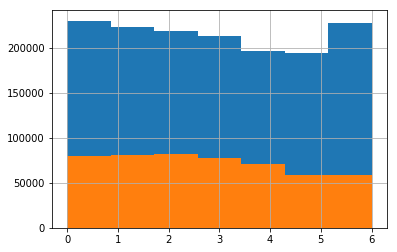

In [9]:
train.activation_date.dt.weekday.hist(bins=7)
test.activation_date.dt.weekday.hist(bins=7)
plt.show()

In [4]:
# Add day features to train
new_features = pd.DataFrame(index=train.index)

new_features = new_features.join(pd.get_dummies(train["activation_date"].dt.weekday))

new_features.columns =['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

new_features.head()

train_features = train_features.join(new_features)

In [5]:
# Add day features to test
new_features = pd.DataFrame(index=test.index)

new_features = new_features.join(pd.get_dummies(test["activation_date"].dt.weekday))

new_features.columns =['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

test_features = test_features.join(new_features)

In [6]:
print(train_features.shape)
print(test_features.shape)

(1503424, 263)
(508438, 263)


## Missing Values

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 11 columns):
item_id             1503424 non-null object
user_id             1503424 non-null object
title               1503424 non-null object
description         1387148 non-null object
price               1418062 non-null float64
item_seq_number     1503424 non-null int64
activation_date     1503424 non-null datetime64[ns]
user_type           1503424 non-null object
image               1390836 non-null object
image_top_1         1390836 non-null float64
deal_probability    1503424 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 126.2+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508438 entries, 0 to 508437
Data columns (total 10 columns):
item_id            508438 non-null object
user_id            508438 non-null object
title              508438 non-null object
description        508438 non-null object
price              477853 non-null float64
item_seq_number    508438 non-null int64
activation_date    508438 non-null datetime64[ns]
user_type          508438 non-null object
image              465829 non-null object
image_top_1        465829 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 38.8+ MB


- Test data has no missing values in description.

In [7]:
from sklearn import impute

In [8]:
indicator = impute.MissingIndicator(missing_values=True,error_on_new=False)

indicator.fit(test.isna())

miss_vars = ['price_miss','image_miss','image_top_1_miss']

new_features = pd.DataFrame(indicator.transform(train.drop('deal_probability',axis=1).isna()),columns=miss_vars)
print('As bool:')
print(new_features.sum())
display(new_features.head())

new_features = new_features.astype(int)
print('\nAs int:')
print(new_features.sum())
display(new_features.head())

As bool:
price_miss           85362
image_miss          112588
image_top_1_miss    112588
dtype: int64


,price_miss,image_miss,image_top_1_miss
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False



As int:
price_miss           85362
image_miss          112588
image_top_1_miss    112588
dtype: int64


,price_miss,image_miss,image_top_1_miss
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [9]:
train_features = train_features.join(new_features)

In [10]:
new_features = pd.DataFrame(indicator.transform(test.isna()),columns=miss_vars)
new_features = new_features.astype(int)
test_features = test_features.join(new_features)

In [11]:
print(train_features.shape)
print(test_features.shape)

(1503424, 266)
(508438, 266)


## Word Lengths
### Description & Title

In [12]:
new_features = pd.DataFrame(index=train.index)

new_features['desc_words'] = train.description.fillna('').apply(lambda x: len(x.split()))

train_features = train_features.join(new_features)

In [13]:
new_features = pd.DataFrame(index=test.index)

new_features['desc_words'] = test.description.fillna('').apply(lambda x: len(x.split()))

test_features = test_features.join(new_features)

In [14]:
print(train_features.shape)
print(test_features.shape)

(1503424, 267)
(508438, 267)


In [15]:
new_features = pd.DataFrame(index=train.index)

new_features['title_words'] = train.title.fillna('').apply(lambda x: len(x.split()))

train_features = train_features.join(new_features)

In [16]:
new_features = pd.DataFrame(index=test.index)

new_features['title_words'] = test.title.fillna('').apply(lambda x: len(x.split()))

test_features = test_features.join(new_features)

In [17]:
print(train_features.shape)
print(test_features.shape)

(1503424, 268)
(508438, 268)


## Imputations
### Price, Image_top_1

In [55]:
print('PRICE\n')
print('Train Median:',np.median(train.price.dropna()))
print('Test Median:',np.median(test.price.dropna()))
print("")
print('Train Mean:',np.mean(train.price.dropna()))
print('Test Mean:',np.mean(test.price.dropna()))

PRICE

Train Median: 1300.0
Test Median: 1500.0

Train Mean: 316708.0884982462
Test Mean: 279818.9459415343


In [58]:
train.price.describe()

count    1.418062e+06
mean     3.167081e+05
std      6.689154e+07
min      0.000000e+00
25%      5.000000e+02
50%      1.300000e+03
75%      7.000000e+03
max      7.950101e+10
Name: price, dtype: float64

In [62]:
print('Image_Top_1\n')
print('Train Median:',np.median(train.image_top_1.dropna()))
print('Test Median:',np.median(test.image_top_1.dropna()))
print("")
print('Train Mean:',np.mean(train.image_top_1.dropna()))
print('Test Mean:',np.mean(test.image_top_1.dropna()))

Image_Top_1

Train Median: 1057.0
Test Median: 1132.0

Train Mean: 1241.9321192433904
Test Mean: 1297.959227527698


In [63]:
train.image_top_1.describe()

count    1.390836e+06
mean     1.241932e+03
std      9.704641e+02
min      0.000000e+00
25%      4.250000e+02
50%      1.057000e+03
75%      2.217000e+03
max      3.066000e+03
Name: image_top_1, dtype: float64

In [18]:
imputer = impute.SimpleImputer(strategy='median')

imputer.fit(train[['price','image_top_1']].append(test[['price','image_top_1']]))

new_features = pd.DataFrame(imputer.transform(train[['price','image_top_1']]))

new_features.columns = ['price_imp','image_top_1_imp']

train_features = train_features.join(new_features)

In [25]:
new_features = pd.DataFrame(imputer.transform(test[['price','image_top_1']]))

new_features.columns = ['price_imp','image_top_1_imp']

test_features = test_features.join(new_features)

In [26]:
print(train_features.shape)
print(test_features.shape)

(1503424, 270)
(508438, 270)


### Item_Seq_Number

In [93]:
train.item_seq_number.describe()

count    1.503424e+06
mean     7.436740e+02
std      5.572522e+03
min      1.000000e+00
25%      9.000000e+00
50%      2.900000e+01
75%      8.800000e+01
max      2.044290e+05
Name: item_seq_number, dtype: float64

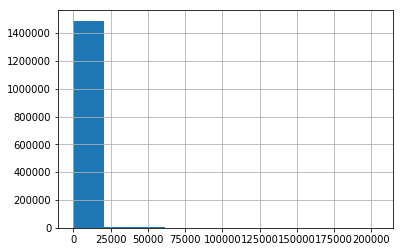

In [94]:
train.item_seq_number.hist()

In [95]:
train_features['seq_n'] = train['item_seq_number']

In [96]:
test_features['seq_n'] = test['item_seq_number']

In [97]:
print(train_features.shape)
print(test_features.shape)

(1503424, 271)
(508438, 271)


---

In [98]:
train_features.to_pickle('train_features.pkl',compression='zip')
test_features.to_pickle('test_features.pkl',compression='zip')

MemoryError: 

```python
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")
```

# Score with Current Features

In [32]:
model = linear_model.LinearRegression()
cv = model_selection.cross_val_score(model,train_features,train.deal_probability,cv=3)
score = np.mean(cv)
print('Score with current features:',score)

Score with current features: 0.1765148041841039


In [86]:
scaler = preprocessing.StandardScaler()

scaled_features = scaler.fit_transform(train_features)

model.fit(scaled_features,train.deal_probability)

coefs = pd.DataFrame()

coefs['feature'] = train_features.columns.tolist()

coefs['coef'] = model.coef_

coefs['absolute'] = np.absolute(coefs['coef'])

In [89]:
model.score(scaled_features,train.deal_probability)

0.1794413717557889

In [101]:
coefs.sort_values(by='absolute',ascending=False)

,feature,coef,absolute
206,Dlja doma i dachi,5.736541e+10,5.736541e+10
254,Private,-5.071664e+10,5.071664e+10
253,Company,-4.737587e+10,4.737587e+10
211,Uslugi,4.074787e+10,4.074787e+10
241,Predlozhenie uslug,-4.074787e+10,4.074787e+10
231,Mebel' i inter'er,-3.605020e+10,3.605020e+10
212,ZHivotnye,3.603556e+10,3.603556e+10
245,Remont i stroitel'stvo,-3.361520e+10,3.361520e+10
256,Sunday,3.294112e+10,3.294112e+10
262,Saturday,3.281609e+10,3.281609e+10


In [109]:
selector = feature_selection.SelectFromModel(model,max_features=20,prefit=True)

In [119]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [114]:
train_features.columns[selector.get_support()]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 271 but corresponding boolean dimension is 270